# Multiple Centrality Assessment

Multiple Centrality Assessment (MCA) is an approach to street network analysis developed by Porta and Latora (2006). Its main aim is to understand the structure of the street networks of our cities from the perspective of the importance and position of each street/intersection within the whole network as expressed by various centralities. Momepy can do all types of MCA-based centrality analysis as were developed through the years.

The aim of this notebook is to illustrate how to measure different centralities using momepy. For the theoretical background, please refer to the work of Porta et al.

In [1]:
import geopandas as gpd
import momepy
import osmnx as ox
import matplotlib.pyplot as plt

In the ideal case, momepy expects a LineString GeoDataFrame containing a street network as a starting point. Either we have our own, or we can use osmnx to dowload network from OSM. In this notebook, we will look at Vicenza, Italy.

In [2]:
streets_graph = ox.graph_from_place('Vicenza, Vicenza, Italy', network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)

/Users/martin/Git/osmnx/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


The code above dowloaded the network from OSM and projected it. At this point, `streets_graph` is networkX Graph object, similar to the one we will use in momepy. In theory, you can use it directly. However, when converting a GeoDataFrame to a network using momepy ensures that all attributes are set and compatible with morphometric functions, so we recommend saving an undirected graph to a gdf and letting momepy do the conversion back to the graph.

In [3]:
edges = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

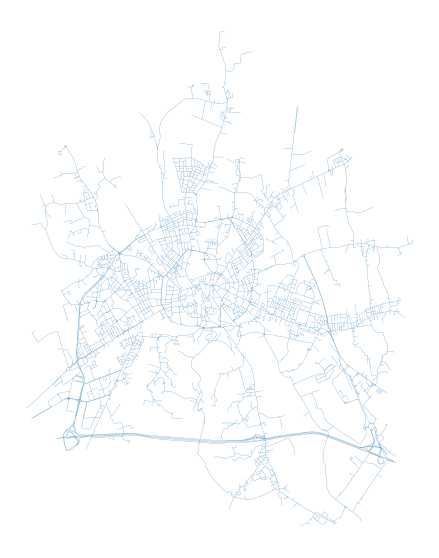

In [4]:
f, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.2)
ax.set_axis_off()
plt.show()

To measure centrality, we have to *convert* gdf to a graph. For that, we can choose from two options of how to represent street networks within a graph. The first, and the most straightforward, one is the primal approach (Porta et al., 2006) where streets are represented by graph edges and intersections by nodes.

## Primal graph

We can generate a networkX.MultiGraph, which is used within momepy, using `gdf_to_nx`.

In [4]:
primal = momepy.gdf_to_nx(edges, approach='primal')

### Closeness centrality

Closeness centrality could be simplified as the average distance to every other node from each node. As such, it can be measured on the whole network (Global Closeness Centrality) or within a certain limit only (Local Closeness Centrality). 

#### Local closeness
To measure local `closeness_centrality` we need to specify a radius (how far we should go from each node). We can use topological distance (e.g. 5 steps, then radius=5) or metric distance (e.g. 400 metres) - then radius=400 and distance=length of each segment saved as a parameter of each edge. By default, momepy saves length as `mm_len`. 

The weight parameter is used for centrality calculation. Again, we can use metric weight (using the same attribute as above) or no weight (weight=None) at all. Or any other attribute we wish.

In [5]:
primal = momepy.closeness_centrality(primal, radius=400, name='closeness400', distance='mm_len', weight='mm_len')

  0%|          | 0/4177 [00:00<?, ?it/s]

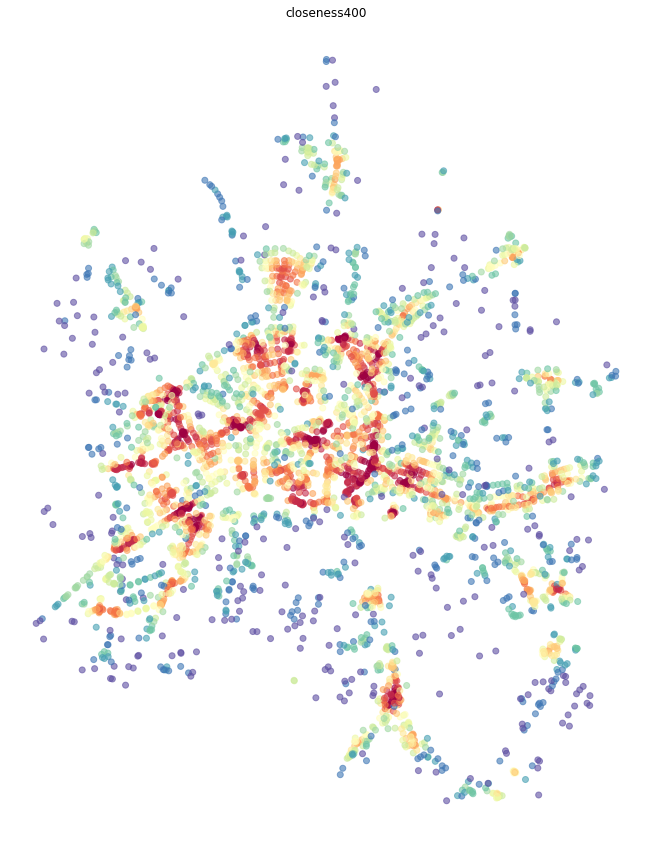

In [7]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='closeness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400')
plt.show()

#### Global closeness

Global closeness centrality is a bit simpler as we do not have to specify radius and distance, the rest remains the same.

In [8]:
primal = momepy.closeness_centrality(primal, name='closeness_global', weight='mm_len')

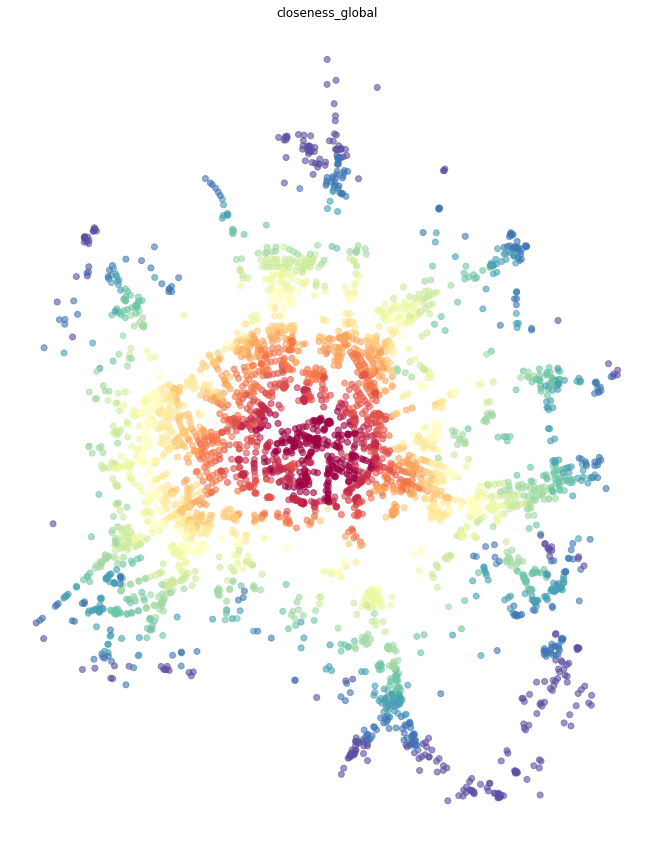

In [9]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='closeness_global', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness_global')
plt.show()

### Betweenness

Betweenness centrality measures the importance of each node or edge for travelling along the network. It measures how many times each node/edge used if we walk using the shortest paths from each node to every other. 

We have two options of how to measure betweenness on primal graphs - on nodes or on edges.

#### Node-based
Node-based betweenness, as the name suggests, measures the betweenness of each node - how many times we would walk through the node.

In [10]:
primal = momepy.betweenness_centrality(primal, name='betweenness_metric_n', mode='nodes', weight='mm_len')

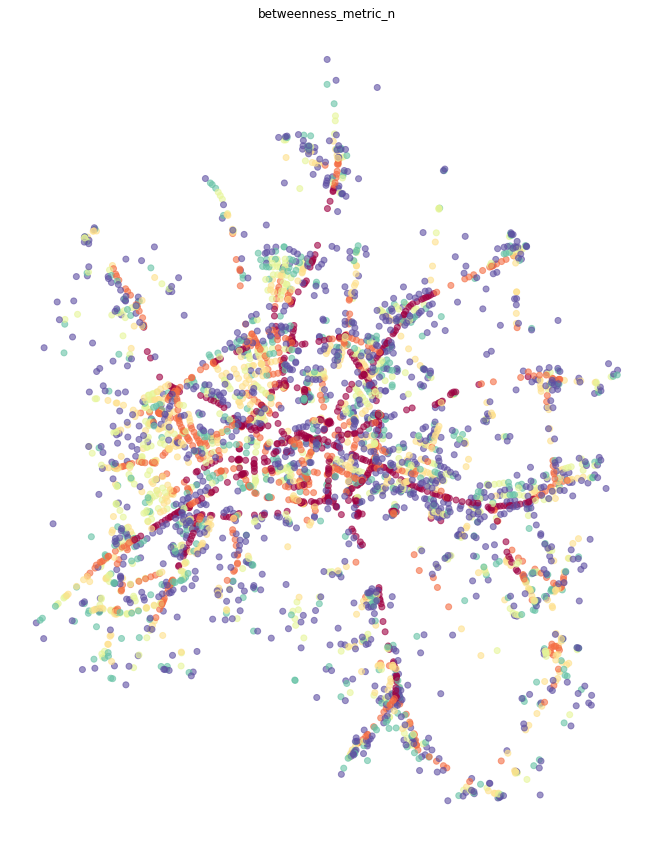

In [11]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=7, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness_metric_n')
plt.show()

#### Edge-based

Edge-based betweenness does the same but for edges: how many times we go through each edge (street).

In [12]:
primal = momepy.betweenness_centrality(primal, name='betweenness_metric_e', mode='edges', weight='mm_len')

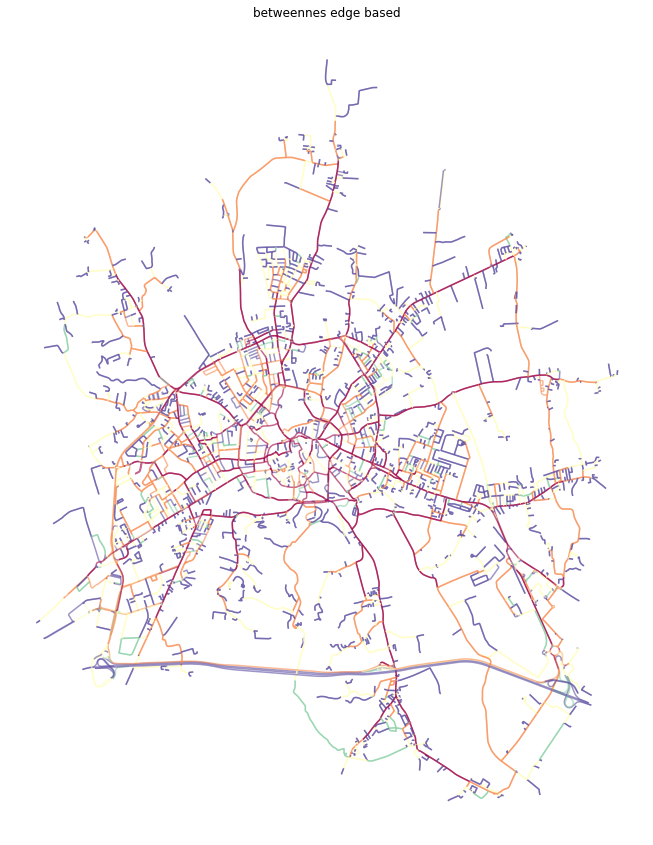

In [13]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='betweenness_metric_e', cmap='Spectral_r', scheme='quantiles', alpha=0.6)
ax.set_axis_off()
ax.set_title('betweennes edge based')
plt.show()

### Straightness

While both closeness and betweenness are generally used in many applications of network analysis, straightness centrality is specific to street networks as it requires a geographical element. It is measured as a ratio between real and Euclidean distance while waking from each node to every other.

In [14]:
primal = momepy.straightness_centrality(primal)

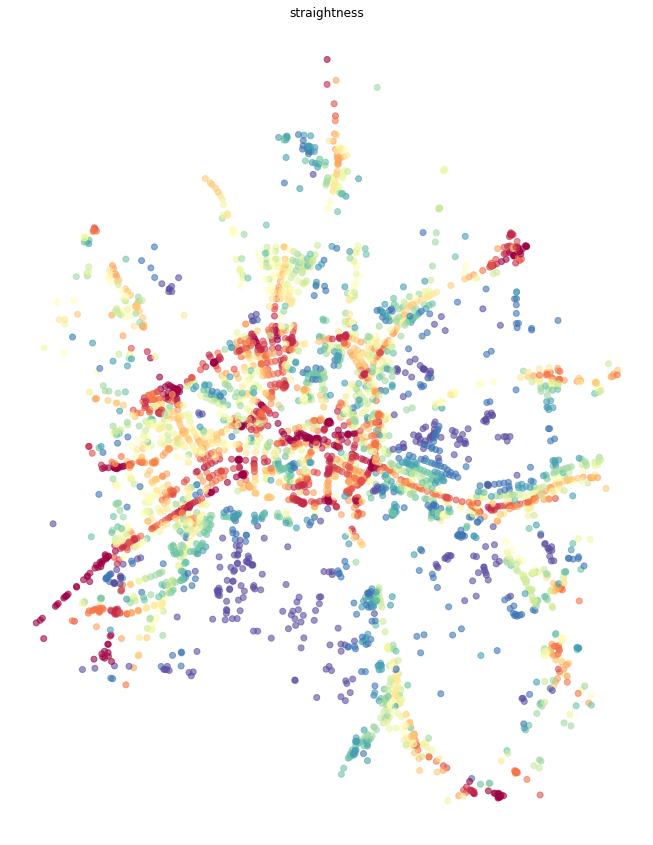

In [15]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('straightness')
plt.show()

### Node values averaged onto edges

In some cases, it is easier to understand centrality results if they are attached to street segments, rather than intersections. We can do an approximation using the mean value attached to start and end node of each edge.

In [16]:
momepy.mean_nodes(primal, 'straightness')
momepy.mean_nodes(primal, 'closeness400')
momepy.mean_nodes(primal, 'closeness_global')
momepy.mean_nodes(primal, 'betweenness_metric_n')

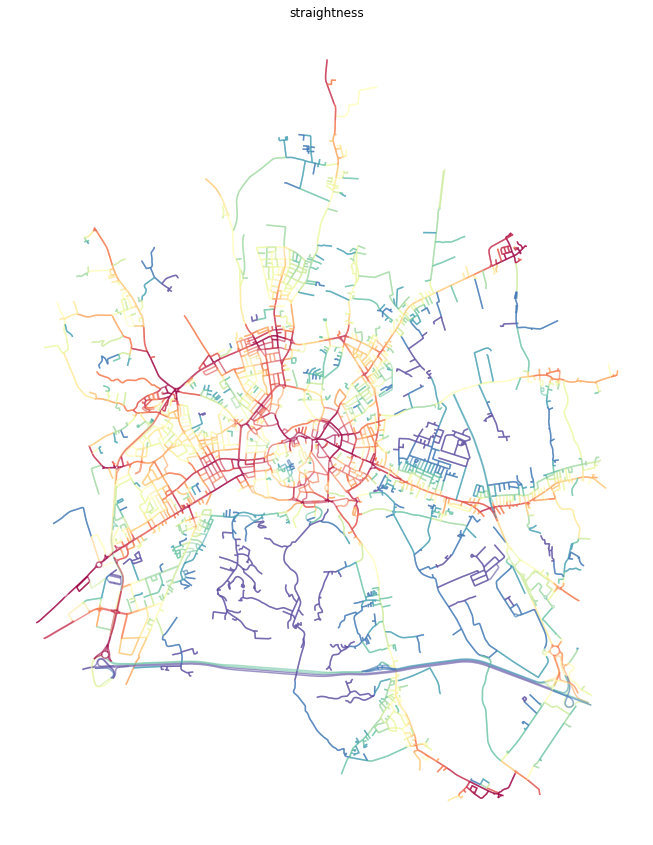

In [17]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)

f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('straightness')
plt.show()

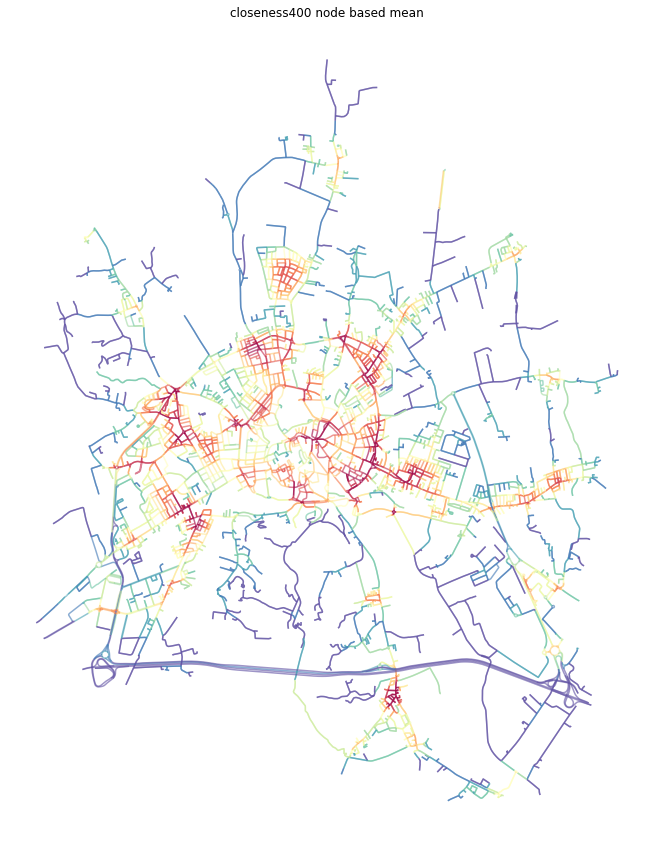

In [18]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='closeness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400 node based mean')
plt.show()

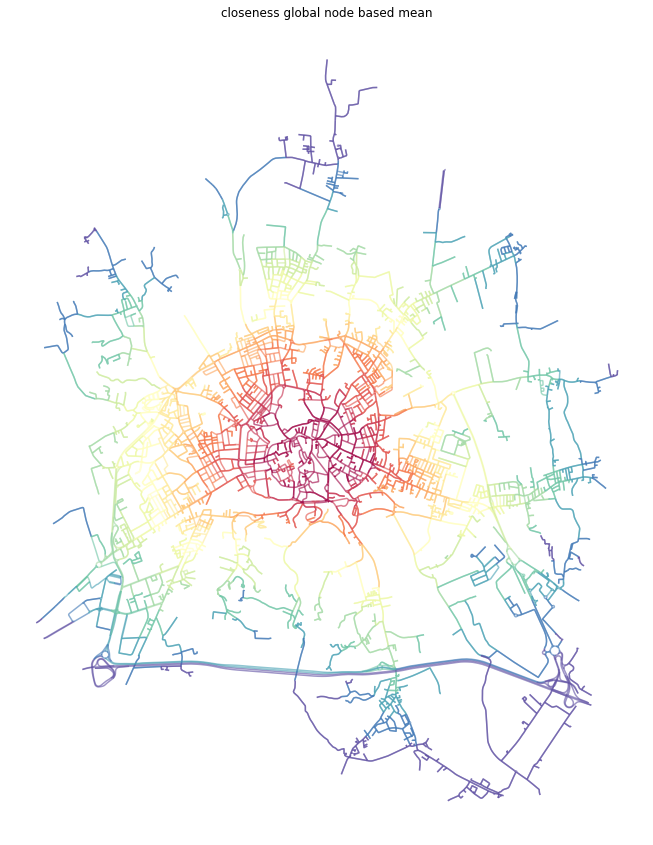

In [19]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='closeness_global', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness global node based mean')
plt.show()

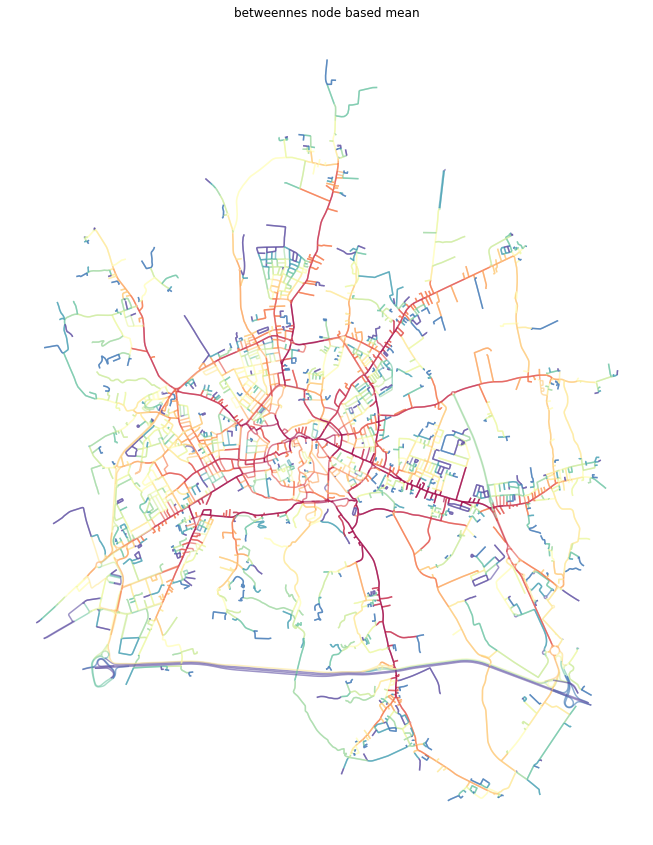

In [20]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweennes node based mean')
plt.show()

Once we have finished our network analysis on the primal graph, we can save both nodes and edges back to GeoDataFrames.

In [21]:
nodes, edges_p = momepy.nx_to_gdf(primal)

### Topological vs metric distances

Centrality can be measured topologically (ignoring physical lengths of street segments) or metrically. Moreover, in the case of local centrality, local subgraphs can be also defined topologically and metrically. In the end, you have four options of how to measure centralilty, illustrated on `betweenness_centrality`:

```py
# topologically defined subgraph (5 steps) and topologically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight=None)

# topologically defined subgraph (5 steps) and metrically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight='edge_length')

# metrically defined subgraph (800 meters) and topologically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight=None)

# metrically defined subgraph (800 meters) and metrically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight='edge_length')
```

## Dual graph

Dual graph is a bit more complicated concept as it represents street segments as nodes with intersections as edges connecting nodes. The geographical distance is lost as edges are of virtually no length, but we can capture the angle between connected streets. Momepy does that by default, using angles between lines connecting the start and end points of each segment. Hence, we can measure angular centrality.

**Note**: Dual graphs have naturally much more connections than primal ones, so computation of centrality on dual graph takes longer.

In [4]:
dual = momepy.gdf_to_nx(edges, approach='dual')

### Angular closeness

The situation with closeness is similar to the one done on primal graphs. We can again do global and local closeness.

#### Local
The difference is that we do not have geographic distance, so we can limit closeness topologically or by another attribute (line angle). The example below uses a topological distance of 5 steps.

In [5]:
dual = momepy.closeness_centrality(dual, radius=5, name='angcloseness400', weight='angle')

100%|██████████| 5419/5419 [00:06<00:00, 897.50it/s] 


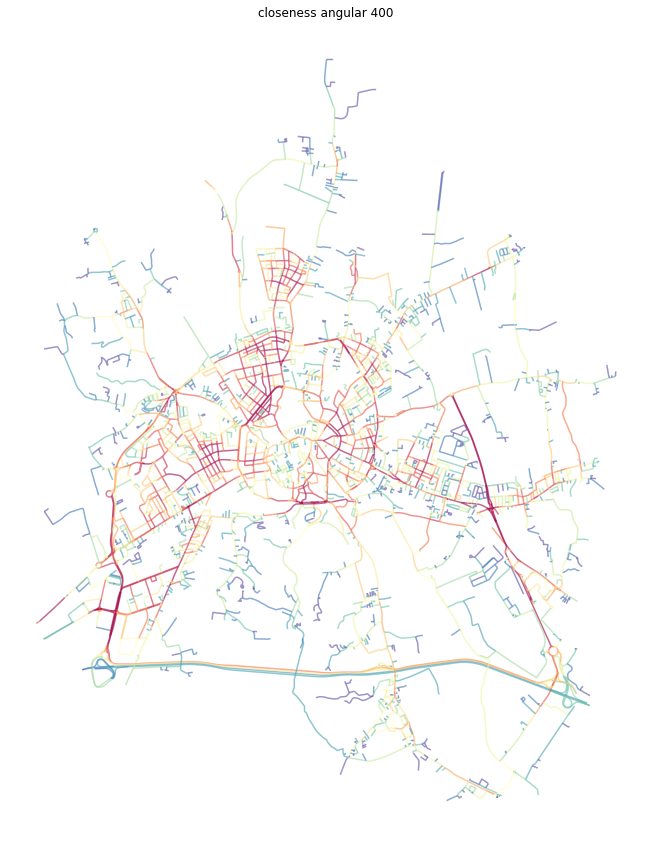

In [6]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)

f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='angcloseness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness angular 400')
plt.show()

#### Global

Global angular closeness is then straightforward.

In [7]:
dual = momepy.closeness_centrality(dual, name='closeness_global_ang', weight='angle')

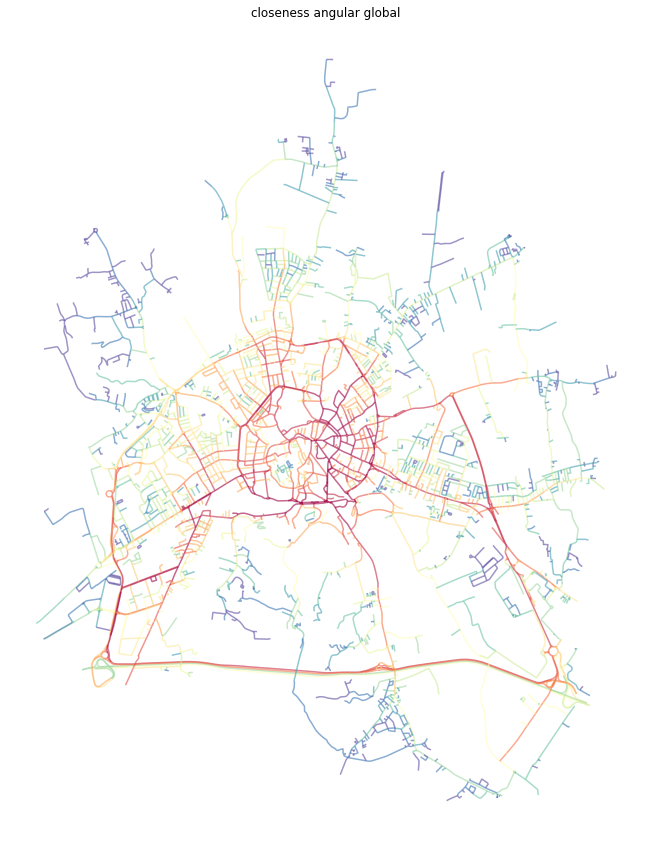

In [8]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='closeness_global_ang', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness angular global')
plt.show()

### Angular betweenness
The last option momepy offers is angular betweenness. Just keep in mind, that nodes and edges are not representing the same concepts and it does not make much sense to measure angular betweenness on edges. Moreover, `nx_to_gdf` converts a dual graph to a LineString gdf only.

In [9]:
dual = momepy.betweenness_centrality(dual, name='angbetweenness', mode='nodes', weight='angle')

/Users/martin/Git/mapclassify/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/martin/Git/mapclassify/mapclassify/classifiers.py:242: UserWarning: Warning: setting k to 13
  Warn("Warning: setting k to %d" % k_q, UserWarning)


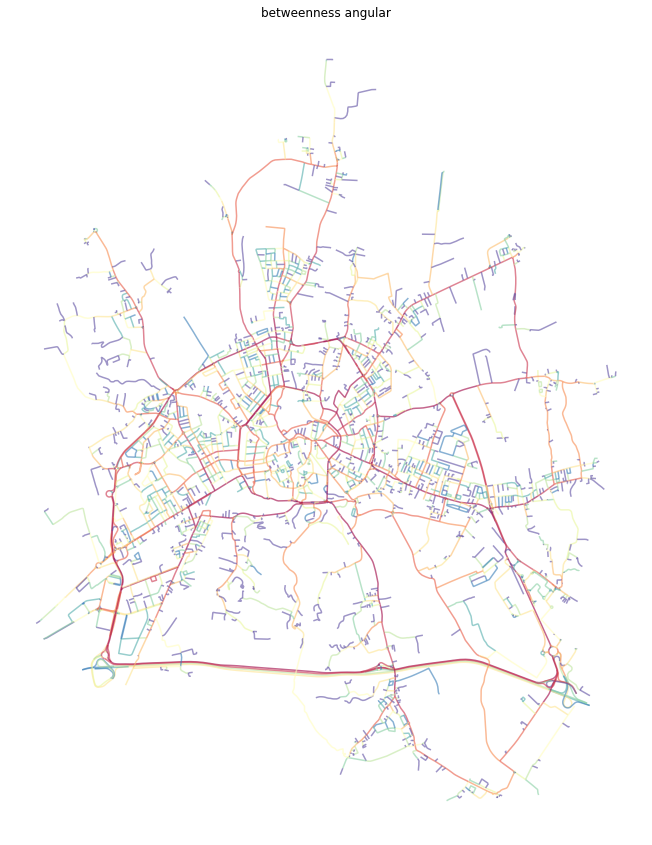

In [10]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='angbetweenness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness angular')
plt.show()

In [29]:
edges_d = momepy.nx_to_gdf(dual)